# Evaluation
> Part 2 of the mangoes_blog project

- branch: master
- toc: true 
- badges: false
- comments: false
- sticky_rank: 2
- author: Huon Fraser
- categories: [mangoes]

In the previous notebook, we introduced the Mangoes data set, performed explanatory analysis for the metadata, and built a linear model. In this notebook we define our evaluation approach for future experiments. We want to avoid contuinously evaluating on test set as then we may be selecting for models that fit this set well due to chance alone. On the other hand, we need to validate the performance of our models at least occasionally. The middleground approach we will take is to select a single model from each notebook to be evaluated on the test set, with this selected by cross-validation on the training data. 

The other element of our evaluation approach is search, we need a method to select hyperparameters. As a starting point we use 50 evaluations for each search. As our models get more complex we may increase this budget, or switch to budgetting based on time. 

In [1]:
# default_exp src.scikit_models
#collapse-hide
import sys
sys.path.append('/notebooks/mangoes_blog_public/src/')
model_path  = '../models/'

import pathlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GroupKFold
from scikit_models import *
from skopt.space import Real, Integer
from lwr import LocalWeightedRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#collapse-hide
mangoes=load_mangoes()
train_data,test_data = train_test_split(mangoes)
train_X, train_y, train_cat = X_y_cat(train_data,min_X=684,max_X=990)
test_X, test_y, test_cat = X_y_cat(test_data,min_X=684,max_X=990)
nrow,ncol=train_X.shape

## Cross-Validation

A ommon cross-validation method for IR-spectra analysis is leave-one-out (in this case fruit), with leave-out-one-population used in applications on Mangoes. However there are concerns that this leads to overfitting, as its likely than for any one particular fruit/pop there is another very similar fruit/pop (As an aside we could measure this by using $kNN_{k=1}$ models, then measuring the deviation between leave-one-out cross-validation scores and train-test scores). Rather we go with the standard 5-fold cross-validation which is a good middle gorund of asking if we can repeat a good level of performance 5 times with decent sized test/validate populations.


The sklearn cross-validate functions ([cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate), [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)), take averages of scores. This is very practial, as it allows them to nest an evaluation function, however returning functions of scores is not ideal. A better method is to combine the test predictions of each fold into a single set and score based of these. For mean squared error (MSE) this doesn't make a difference, but for an $R^2$ score, performance may be completely different. It also allows us to plot our results. A requirement for this to work is that each instance in a training set is used for testing only once (s.t. there is one unique prediction for each instance).

Below we define our cross-validation function and an accompanying function to evaluate a model on the test data.

In [3]:
#export

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold

def cross_validate(model,X,y,splitter=GroupKFold(),groups=None,plot=False,save_loc=None):
    preds = None 
    ys = None
    for fold, (inds1,inds2) in enumerate(splitter.split(X,y,groups)):
        model.fit(X.iloc[inds1,:],y.iloc[inds1,:])
        pred = model.predict(X.iloc[inds2,:])
        
        if preds is None:
            preds = pred
            ys = y.iloc[inds2,:]
        else:
            preds = np.concatenate((preds,pred),axis=0)
            ys = np.concatenate((ys,y.iloc[inds2,:]),axis=0)
                
    r2 = r2_score(ys,preds)
    mse = mean_squared_error(ys,preds)


    if plot:
        ys = ys.flatten()
        preds = preds.flatten()
        
        m, b = np.polyfit(ys, preds, 1)
        fig, ax = plt.subplots()
        
        ls = np.linspace(min(ys),max(ys))
        ax.plot(ls,ls*m+b,color = "black", label = r"$\hat{y}$ = "+f"{m:.4f}y + {b:.4f}")
        ax.scatter(x=ys,y=preds,label = r"$R^2$" + f"={r2:.4f}")

        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.legend(bbox_to_anchor=(0.5,1))
        if not save_loc is None:
            fig.savefig(save_loc)
    return mse

def evaluate(model,train_X,train_y,test_X,test_y,plot=False,save_loc=None,log=True):
    test_y=test_y.values.flatten()
    model.fit(train_X,train_y)
    preds = model.predict(test_X)
    
    r2 = r2_score(test_y,preds)
    mse = mean_squared_error(test_y,preds)

    if log:
        print(f"Test set MSE: {mse:.4f}")
    
    if plot:
        preds=preds.flatten()
        
        m, b = np.polyfit(test_y, preds, 1)
        fig, ax = plt.subplots()
        
        ls = np.linspace(min(test_y),max(test_y))
        ax.plot(ls,ls*m+b,color = "black", label = r"$\hat{y}$ = "+f"{m:.4f}y + {b:.4f}")
        ax.scatter(x=test_y,y=preds,label = r"$R^2$" + f"={r2:.4f}")

        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.legend(bbox_to_anchor=(0.5,1))
        if not save_loc is None:
            fig.savefig(save_loc)
    return model, mse
    

### Grouping instance

We use grouped KFold, with grouping done by Pop. As an exercise we show the effect of grouping by comparing to groups by FruitID and no grouping. Mixing populations between folds (grouping by fruit or no grouping) significantly improves validation performance. As the test set includes different populations, this won't effect the results of the final model, however it may effect our decision of model to select. From here onwards we use grouping by Pop. 

Our specific problem is to build a model based of the given populations that can extrapolate to unseen populations, so validating wtih groups based of Pop will give a better indication of the true performance than other methods.

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

#group by pop
groups = train_data['Pop']
splitter = GroupKFold(n_splits=5)
print(f'Grouped by Pop, MSE =  {cross_validate(model,train_X,train_y,splitter=splitter,groups=groups)}') 

#group by Fruit_ID
groups = train_data['Fruit_ID']
splitter = GroupKFold(n_splits=5)
print(f'Grouped by Fruit, MSE =  {cross_validate(model,train_X,train_y,splitter=splitter,groups=groups)}') 

#group by 
splitter= KFold(shuffle=True)
print(f'No Grouping, MSE =  {cross_validate(model,train_X,train_y,splitter=splitter,groups=groups)}') 

Grouped by Pop, MSE =  0.8236810194689146
Grouped by Fruit, MSE =  0.6800524561711946
No Grouping, MSE =  0.6748251329051893


## Search

Our task for search is to define a search procudure. Since we've defined a custom cross-valdiation method, the sklearn  grid_search_cv and random_search cv won't work.  Luckily the [scikit-optimize](https://scikit-optimize.github.io/) (skopt) package provides a more powerful interface for Bayesian optimisation that we can take advantage of.

We create an interface for the the skopt package, by first defining objective function, which takes a search space and returns a  score based on cross-validation results. Any extra parameters for cross validation are defined in initialisation. We then define an optimise function, which wraps our search with nice things like tqdm progress bars and optional outputs This function returns a copy of the model with parameters set to found solution and a dictionary of the search results. All the heavy lifting here is done by the gp_minimize function, which runs Bayesian optimsiation based around a Gaussian process regression kernel. In the future we could extend this to use different kernels. 

To create our grid-search and random-search methods, we cheat a little and use the initialisation methods from skopt. Random is just that, while grid search will devide the parameter space evenly to match the number of calls. This approach allows us to run Bayesian, random, and grid search using the same definitions of inputs and recieving the same outputs. 

In [5]:
#export
from tqdm import tqdm
from codetiming import Timer

from skopt import gp_minimize,dump
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt.callbacks import VerboseCallback

class TqdmCallback(tqdm):

    def __call__(self, res):
        super().update()

    def __getstate__(self):
        return []
    def __setstate__(self, state):
        pass

class Optimiser():
    
    def __init__(self,space,model,X,y,splitter=KFold(),groups=None):
        self.space=space
        self.model=model
        self.X=X
        self.y=y
        self.splitter=splitter
        self.groups=groups
    

    def objective(self,**params):
        self.model.set_params(**params)
        return cross_validate(self.model, self.X, self.y, splitter=self.splitter,groups=self.groups)

    def bayesian_optimise(self,n_calls=50,random_state=0):
        obj = use_named_args(self.space)(self.objective)
        return gp_minimize(obj,self.space,n_calls=n_calls,random_state=random_state,callback=TqdmCallback(total=n_calls))
    
    def random_optimise(self,n_calls=50, random_state=0):
        obj = use_named_args(self.space)(self.objective)
        return gp_minimize(obj,self.space,n_calls=n_calls,n_initial_points=n_calls,initial_point_generator='random',
                             random_state=random_state,callback=TqdmCallback(total=n_calls))

    def grid_optimise(self,n_calls=50, random_state=0):
        obj = use_named_args(self.space)(self.objective)
        return gp_minimize(obj,self.space,n_calls=n_calls,n_initial_points=n_calls,initial_point_generator='grid',
                             random_state=random_state,callback=TqdmCallback(total=n_calls))
    
    
    @Timer()
    def optimise(self,strategy="bayesian",n_calls=50, random_state=0,plot=True,save_file=None,log=True):


        if strategy=="bayesian":
            result = self.bayesian_optimise(n_calls=n_calls, random_state=random_state)
        elif strategy=="grid":
            result = self.grid_optimise(n_calls=n_calls, random_state=random_state)
        elif strategy=="random":
            result = self.random_optimise(n_calls=n_calls, random_state=random_state)
            
        #set parameters of model
        params = {dim.name:result['x'][i] for i,dim in enumerate(self.space)}
        model = self.model.set_params(**params)
        
        #save model and search
        if not save_file is None:
            del result.specs['args']['func'] #spaghetti code to not throw an error as the objective function is unserialisable 
            dump(result,save_file+'_search.pkl')
            dump(model, save_file+'_model.joblib') 
            
        #plot
        if plot:
            plot_convergence(result)
            
        # log/print results and include a regression plot:
        if log:
            print(f'Best model had an MSE of {result.fun:.4f}')
            print(f'Setting parameters as: {params}')
            
            if save_file is None:
                cross_validate(model, self.X,self.y,splitter=self.splitter,groups=self.groups,plot=True,save_loc=None)
            else:
                cross_validate(model, self.X,self.y,splitter=self.splitter,groups=self.groups,plot=True,save_loc=save_file+'_plot.png')
 
        return model,result



## Search for L2 Regularisation

We run each search variant below for the problem of finding an appropriate level of $l_2$ regularisation to add to a linear regression alongside a standardisation scheme.

To run our search we first define a model, which should be an sklearn type regression model. We then define our search space, with each dimension defined using one of skopt's provided classes (Integer, Float, Categorical). For each dimension we define the the range of values. For categorical variables this is an explicit, list, while for real values (floats and integers) we defined the start and end range. We can also define log$_{10}$ sampling for numerical values. 

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
pipe = Pipeline([('scaler',StandardScaler()),
                 ('model',Ridge())
                ])

space  = [
    Integer(0,1,name='scaler__with_mean'),
    Integer(0,1,name='scaler__with_std'), 
    Real(1e-3, 1e3, name='model__alpha',prior='log-uniform')
]
groups = train_data['Pop']
splitter=GroupKFold()
opt = Optimiser(space,pipe,train_X,train_y,splitter=splitter,groups=groups)

We demonstrate results for each class of search below. After our optimiser class is declared we can run multiple searches with no overhead. If we are unhappy with the results we can increase the number of calls or attempt a different seed.

Running Grid Search


100%|██████████| 50/50 [00:09<00:00,  2.79it/s]

Best model had an MSE of 0.8157
Setting parameters as: {'scaler__with_mean': 1, 'scaler__with_std': 1, 'model__alpha': 0.005623413251903491}
Elapsed time: 11.0227 seconds


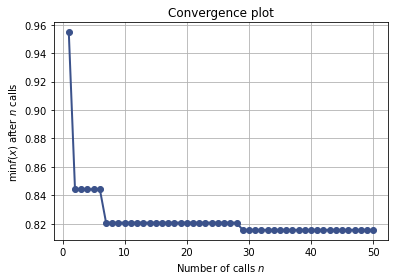

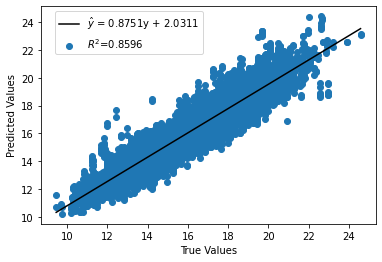

In [7]:
print('Running Grid Search')
model_grid,result_grid= opt.optimise(strategy="grid",save_file=model_path+'2_linear_grid')

Running Random Search



100%|██████████| 50/50 [00:09<00:00,  3.05it/s]

Best model had an MSE of 0.8180
Setting parameters as: {'scaler__with_mean': 0, 'scaler__with_std': 1, 'model__alpha': 0.019920586766671106}
Elapsed time: 10.6795 seconds


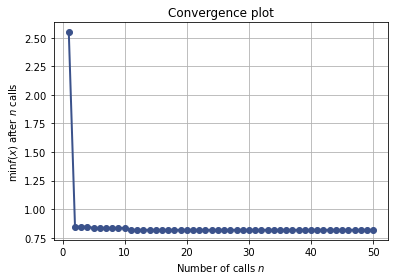

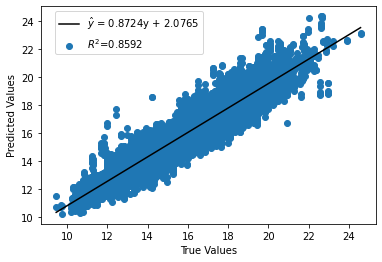

In [8]:
print('Running Random Search')
model_rand,result_rand = opt.optimise(strategy="random",save_file=model_path+'2_linear_random')

Running Bayesian Search




  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:08,  6.11it/s]

  4%|▍         | 2/50 [00:00<00:08,  5.80it/s]

  6%|▌         | 3/50 [00:00<00:07,  6.41it/s]

  8%|▊         | 4/50 [00:00<00:07,  5.81it/s]

 10%|█         | 5/50 [00:00<00:08,  5.47it/s]

 12%|█▏        | 6/50 [00:01<00:08,  5.34it/s]

 14%|█▍        | 7/50 [00:01<00:08,  5.29it/s]

 16%|█▌        | 8/50 [00:01<00:08,  5.06it/s]

 18%|█▊        | 9/50 [00:01<00:07,  5.17it/s]

 20%|██        | 10/50 [00:02<00:11,  3.40it/s]

 22%|██▏       | 11/50 [00:02<00:13,  2.88it/s]

 24%|██▍       | 12/50 [00:03<00:14,  2.56it/s]

 26%|██▌       | 13/50 [00:03<00:15,  2.45it/s]

 28%|██▊       | 14/50 [00:04<00:15,  2.37it/s]

 30%|███       | 15/50 [00:04<00:15,  2.32it/s]

 32%|███▏      | 16/50 [00:04<00:15,  2.26it/s]

 34%|███▍      | 17/50 [00:05<00:14,  2.21it/s]

 36%|███▌      | 18/50 [00:05<00:14,  2.22it/s]

 38%|███▊      | 19/50 [00:06<00:15,  2.03it/s]

 40%|████      | 20/50 [00:06<00:14,

Best model had an MSE of 0.8157
Setting parameters as: {'scaler__with_mean': 1, 'scaler__with_std': 1, 'model__alpha': 0.006159146375736338}
Elapsed time: 28.0659 seconds


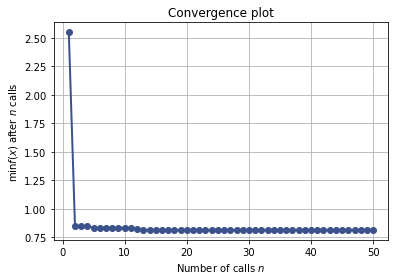

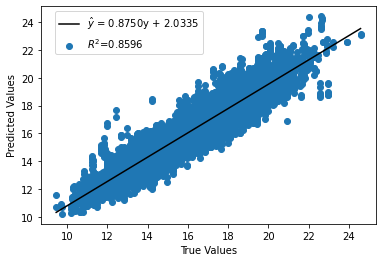

In [9]:
print('Running Bayesian Search')
model_bayes,result_bayes= opt.optimise(strategy="bayesian",save_file=model_path+'2_linear_bayes')

Results across search were indifferent to mean centring, but scaled variance and added a small amount of $l_2$ regularisation. Bayesian and random search converge much quicker than grid search, with Bayesian search returning the best result by a small margin. 

## Summary

This notebook has introduced our cross validation and search schemes. We used these search schemes to find an optimal $l_2$ regularisation and standardisation scheme.
The selected model gave a training MSE of 0.8156. On the test set (shown below) this model scores an MSE of 1.091, a slight improvement upon the 1.1290 (-0.0380) scored by the base linear regression from the last notebook.

Test set MSE: 1.1147


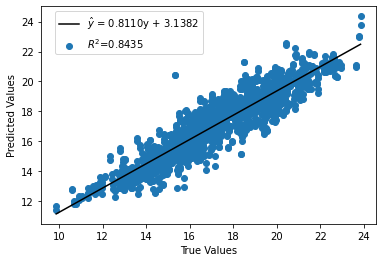

In [10]:
model_bayes,mse_test = evaluate(model_bayes,train_X,train_y,test_X,test_y,plot=True,log=True)